[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/CompOmics/EUPA_2025_DIA/blob/main/workshop/Workshop_EuPA2025.ipynb)

https://github.com/CompOmics/EUPA_2025_DIA/blob/main/workshop/Workshop_EuPA2025.ipynb

![QR](https://github.com/CompOmics/EUPA_2025_DIA/blob/main/workshop/img/qr.png?raw=true)

In [1]:
import os
import gzip
import shutil
import pickle
import random
from pathlib import Path
from collections import defaultdict
from itertools import combinations, combinations_with_replacement, product, chain
import urllib

# Visualization and data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from tqdm import tqdm

# Proteomics libraries
import pyopenms as pms
from pyopenms import MSExperiment, MzMLFile
from pyteomics import mzml
from pyteomics.mass.mass import std_aa_mass
import spectrum_utils as su

In [2]:
# Uncomment below to install required packages, this is required for colab
# !pip install seaborn spectrum_utils pyopenms pyteomics tqdm seaborn matplotlib pandas numpy

# 1. A deep dive into limitations of modification searching for DIA data

Data-Dependent Acquisition (DDA) and Data-Independent Acquisition (DIA) are the two most common acqisition methods in mass spectrometry. Especially in recent years DIA has become more popular for its ability to be highly reproducible and potentially be more sensitive. The data from DIA is however much more complex to interpret and needs sophisticated data analysis methods to reach this potential.

DDA vs. DIA: Fundamental Differences

Data-Dependent Acquisition (DDA) generally selects ions based on their intensity from an MS1 scan. Based on the m/z ions are isolated within a specified isolation windows, these precursor ions are then fragmented (MS2), and the resulting spectra are used to identify peptides. This method focuses on the most abundant ions in each scan cycle. This is shown in the first figure where the DDA acquisition cycle (bottom) alternates between a full scan (MS1) and targeted MS2 scans of selected ions. It is important to note that DDA still has isolation windows wide enough to isolate multiple precursors of different peptidoform origin.

In contrast, Data-Independent Acquisition (DIA) collects data across a wider range of m/z values without prior ion selection. Instead, DIA is preconfigured to specific isolation windows, fragmenting all ions in these preconfigured isolation windows. DIA allows for more comprehensive and unbiased acquisition, capturing information from all ions, which increases sensitivity and data completeness compared to DDA. However, the complexity of the data makes it harder to assign spectra to specific peptides due to overlapping signals and unknown origins of signals.

![dda_vs_dia](https://github.com/CompOmics/EUPA_2025_DIA/blob/main/workshop/img/1_ddavsdia.png?raw=true)

Open Modification Searches: Challenges

In both DDA and DIA, the identification of modified peptides is challenging. These challenges become even more pronounced as the number of modifications included in the search space increases, with ambiguity growing disproportionately for each additional modification. Furthermore, when searching for a large number of modifications there are not only issues with identification ambiguity, but also the search space introduces computational challenges.

![issues search](https://github.com/CompOmics/EUPA_2025_DIA/blob/main/workshop/img/2_issues_search.png?raw=true)

In DDA, the identification is typically more straightforward since it aims to isolate a single peptidoform for fragmentation. This selective nature helps narrow down the search space. However, in DIA, all ions in a given m/z window are fragmented simultaneously, leading to more complex spectra. The broader acquisition means more overlapping peaks and increased ambiguity in the interpretation of modification sites, as the data includes multiple co-eluting peptides.

Computational Issues and Ambiguities

The third figure highlights one significant computational issue: ambiguity in peptide identification during open modification searches. For example, a peptide sequence, such as EEIFGPVM[Oxidation]QLIK and EEIFGP[Oxidation]VQPLFK. Both sequences are equally valid, but resolving them requires careful consideration of retention time and ion fragmentation patterns. Which can be (partly) resolved with predictions, but as we will see later this is still very difficult for DIA data.

![issues search](https://github.com/CompOmics/EUPA_2025_DIA/blob/main/workshop/img/3_resolving_ambiguity.png?raw=true)

# 2. Download all files

## 2.1 mzML files

In [3]:
# List of URLs to download and extract
urls = [
    "https://genesis.ugent.be/uvpublicdata/workshop_2025_eupa/LFQ_Orbitrap_AIF_Human_01.mzML.gz",
    "https://genesis.ugent.be/uvpublicdata/workshop_2025_eupa/LFQ_Orbitrap_DDA_Human_01.mzML.gz"
]

for url in urls:
    # Determine filenames
    output_gz = Path(url.split("/")[-1])
    output_mzml = output_gz.with_suffix("")  # Remove '.gz'

    print(f"Processing: {output_gz.name}")

    # Step 1: Download the file
    with urllib.request.urlopen(url) as response, open(output_gz, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)

    # Step 2: Decompress the file
    with gzip.open(output_gz, 'rb') as f_in, open(output_mzml, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

    # Optional: remove the .gz file
    output_gz.unlink()

    print(f"Extracted: {output_mzml.resolve()}\n")

Processing: LFQ_Orbitrap_AIF_Human_01.mzML.gz
Extracted: C:\Users\robbi\OneDrive - UGent\Documents\2025\Conferences\eupa\analysis\EUPA_2025_DIA\workshop\LFQ_Orbitrap_AIF_Human_01.mzML

Processing: LFQ_Orbitrap_DDA_Human_01.mzML.gz
Extracted: C:\Users\robbi\OneDrive - UGent\Documents\2025\Conferences\eupa\analysis\EUPA_2025_DIA\workshop\LFQ_Orbitrap_DDA_Human_01.mzML



## 2.2 Other files

In [4]:
# Define URLs and local filenames
files_to_download = {
    "https://raw.githubusercontent.com/CompOmics/EUPA_2025_DIA/refs/heads/main/workshop/data/human_22032024.fasta": "human_22032024.fasta",
    "https://raw.githubusercontent.com/CompOmics/EUPA_2025_DIA/refs/heads/main/workshop/data/report.tsv": "report.tsv",
    "https://raw.githubusercontent.com/CompOmics/EUPA_2025_DIA/refs/heads/main/workshop/data/prosit_ptm_2020.csv" : "prosit_ptm_2020.csv",
}

# Create local directory if needed
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

# Download each file
for url, filename in files_to_download.items():
    local_path = data_dir / filename
    print(f"Downloading {filename}...")
    urllib.request.urlretrieve(url, local_path)
    print(f"Saved to {local_path}")

Saved to data\human_22032024.fasta
Saved to data\report.tsv
Saved to data\prosit_ptm_2020.csv


# 3. Visualize MS1 & MS2

For this workshop we will use samples from human K562 cells. The data were acquired on a Thermo Orbitrap QE HF-X instrument in both DDA and DIA (AIF) mode with 8 m/z staggered windows. More details about the dataset can be found in [Van Puyvelde et al.](https://www.nature.com/articles/s41597-022-01216-6).
![data source](https://github.com/CompOmics/EUPA_2025_DIA/blob/main/workshop/img/4_datasource_bvp.png?raw=true)

First we will have a look at the special nature of DIA data where the isolation window is set much wider and the isolation windows follow up each other in a iterative fashion. This is important as likely many more precursors are within the same isolation window and the isolation is consistent between experiments and cover the full m/z range of interest.

Lets first read the .mzML file of the run:

In [5]:
# Path to your mzML file
mzml_file = 'LFQ_Orbitrap_AIF_Human_01.mzML'

def read_mzmzl(mzml_file,break_after_n_spectra=200000):
    ms1_to_scan = {}
    ms1_to_ms2 = {}
    
    # Open the mzML file and read the spectra
    with mzml.MzML(mzml_file) as reader:
        for idx, spectrum in enumerate(reader):
            if spectrum['ms level'] == 1:
                ms_1_scan_nr = int(spectrum.get('id', '').split('scan=')[1].split()[0])
                ms1_to_scan[ms_1_scan_nr] = spectrum
            elif spectrum['ms level'] == 2:
                ms_2_scan_nr = int(spectrum.get('id', '').split('scan=')[1].split()[0])
                if ms_1_scan_nr in ms1_to_ms2.keys():
                    ms1_to_ms2[ms_1_scan_nr][ms_2_scan_nr] = spectrum
                else:
                    ms1_to_ms2[ms_1_scan_nr] = {}
                    ms1_to_ms2[ms_1_scan_nr][ms_2_scan_nr] = spectrum
    
            # Only process first n spectra for performance
            if idx > break_after_n_spectra:
                break
    return ms1_to_scan, ms1_to_ms2

ms1_to_scan, ms1_to_ms2 = read_mzmzl(mzml_file)

Next we define some helper functions for plotting. There are in total three functions:

1. **get_random_ms_specs** - select a random MS1 and an MS2 (that are "linked") from the read file. Return all relevant information for plotting
2. **get_ms_specs_scan** - based on a specific MS1 and MS2 scan number return the spectra
3. **create_ms_plot** - plot the MS1 and MS2 spectra. For the MS1 indicate the region that is isolated

In [6]:
def get_random_ms_specs(ms1_to_scan,ms1_to_ms2):
    # Select a random MS1 spectrum
    random_ms1 = random.choice(list(ms1_to_scan.keys()))
    ms1_spectrum = ms1_to_scan[random_ms1]
    mz1, intensity1 = np.array(ms1_spectrum['m/z array']), np.array(ms1_spectrum['intensity array'])
    
    # Assuming the precursor information is available in the MS1 spectrum
    precursor_mz1 = ms1_spectrum.get('precursorMz', np.nan)  # Precursor m/z (if available)
    precursor_charge1 = ms1_spectrum.get('precursorCharge', 1)  # Precursor charge (if available)
    
    # Select a random MS2 spectrum related to the random MS1 spectrum
    random_ms2 = random.choice(list(ms1_to_ms2[random_ms1].keys()))
    ms2_spectrum = ms1_to_ms2[random_ms1][random_ms2]
    mz2, intensity2 = np.array(ms2_spectrum['m/z array']), np.array(ms2_spectrum['intensity array'])
    
    # Get the precursor m/z of the MS2 spectrum (for the isolation window)
    precursor_mz2 = ms2_spectrum['precursorList']['precursor'][0]['isolationWindow']['isolation window target m/z']
    isolation_width = ms2_spectrum['precursorList']['precursor'][0]['isolationWindow']['isolation window lower offset']

    return mz1, intensity1, ms1_spectrum, random_ms1, mz2, intensity2, ms2_spectrum, random_ms2, precursor_mz2, isolation_width

def get_ms_specs_scan(ms1_to_scan,ms1_to_ms2,ms1_scan,ms2_scan):
    ms1_spectrum = ms1_to_scan[ms1_scan]
    mz1, intensity1 = np.array(ms1_spectrum['m/z array']), np.array(ms1_spectrum['intensity array'])
    
    # Assuming the precursor information is available in the MS1 spectrum
    precursor_mz1 = ms1_spectrum.get('precursorMz', np.nan)  # Precursor m/z (if available)
    precursor_charge1 = ms1_spectrum.get('precursorCharge', 1)  # Precursor charge (if available)
    
    ms2_spectrum = ms1_to_ms2[ms1_scan][ms2_scan]
    mz2, intensity2 = np.array(ms2_spectrum['m/z array']), np.array(ms2_spectrum['intensity array'])
    
    # Get the precursor m/z of the MS2 spectrum (for the isolation window)
    precursor_mz2 = ms2_spectrum['precursorList']['precursor'][0]['isolationWindow']['isolation window target m/z']
    isolation_width = ms2_spectrum['precursorList']['precursor'][0]['isolationWindow']['isolation window lower offset']

    return mz1, intensity1, ms1_spectrum, mz2, intensity2, ms2_spectrum, precursor_mz2, isolation_width

def create_ms_plot(mz1,intensity1, ms1_spectrum, mz2, intensity2, ms2_spectrum, precursor_mz2, isolation_width):
    # Plot MS1 spectrum using stem plot (vertical lines for each peak)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15/2, 6/2))
    
    markerline, stemlines, baseline = ax1.stem(mz1, intensity1, basefmt=" ", markerfmt=" ", linefmt='C0-')
    plt.setp(stemlines, 'linewidth', 0.5)
    # Highlight the isolation window around the precursor in MS1
    
    # Highlight the isolation window around the precursor in MS2 (for MS1 plot)
    if not np.isnan(precursor_mz2):
        ax1.axvspan(precursor_mz2 - isolation_width, precursor_mz2 + isolation_width, color='red', alpha=0.5, label='Precursor Isolation Window')
    
    ax1.set_xlabel('m/z')
    ax1.set_ylabel('Intensity')
    ax1.set_title(f'MS1 Spectrum: Scan {random_ms1}')
    ax1.grid(True)
    ax1.legend()
    
    markerline, stemlines, baseline = ax2.stem(mz2, intensity2, basefmt=" ", markerfmt=" ", linefmt='C1-')
    plt.setp(stemlines, 'linewidth', 0.5)
    ax2.set_xlabel('m/z')
    ax2.set_ylabel('Intensity')
    ax2.set_title(f'MS2 Spectrum: Scan {random_ms2}')
    ax2.grid(True)
    plt.show()

Next we will fetch a random spectrum MS1 and associated MS2 and visualize them:

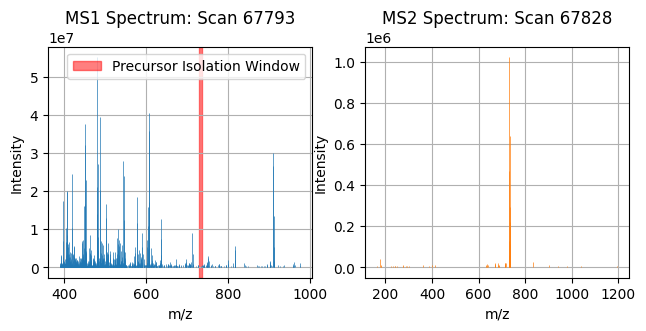

In [7]:
mz1, intensity1, ms1_spectrum, random_ms1, mz2, intensity2, ms2_spectrum, random_ms2, precursor_mz2, isolation_width = get_random_ms_specs(ms1_to_scan,ms1_to_ms2)
create_ms_plot(mz1,intensity1, ms1_spectrum, mz2, intensity2, ms2_spectrum, precursor_mz2, isolation_width)

As this is DIA data we collect many more MS2 spectra consecutively, so for the MS1 previously defined lets go through the next 50 MS2 spectra:

Could not find the associated spectrum, skipping ...


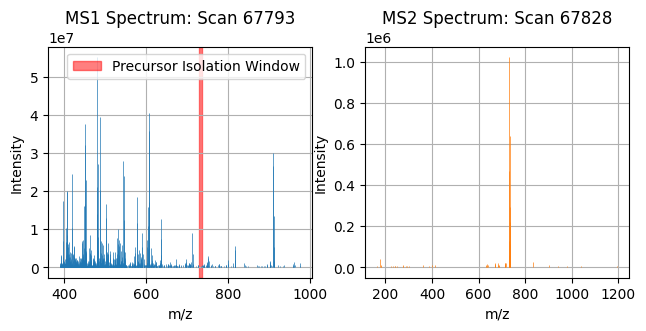

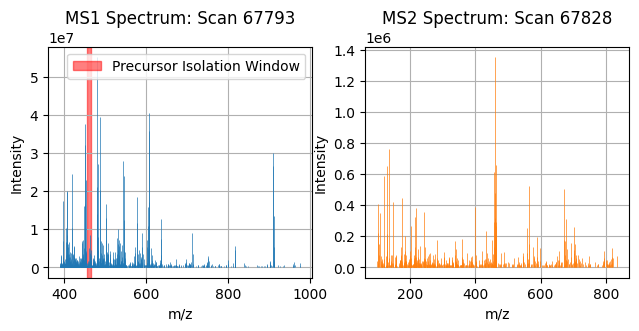

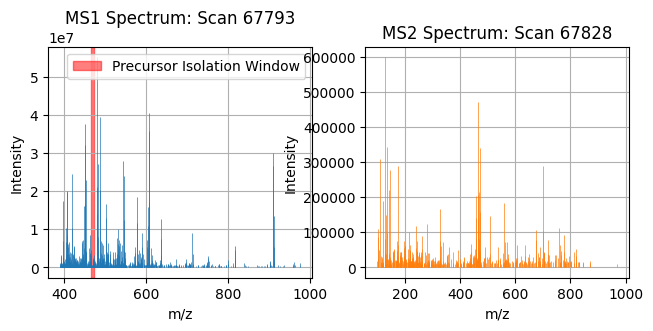

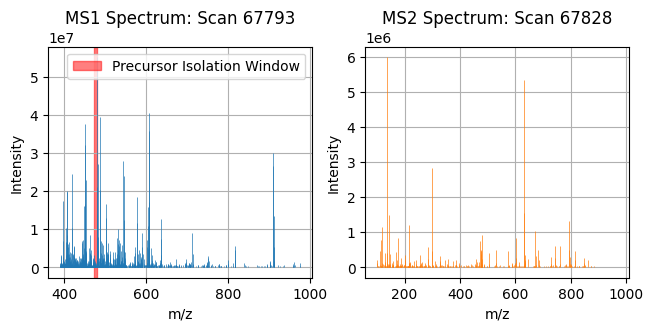

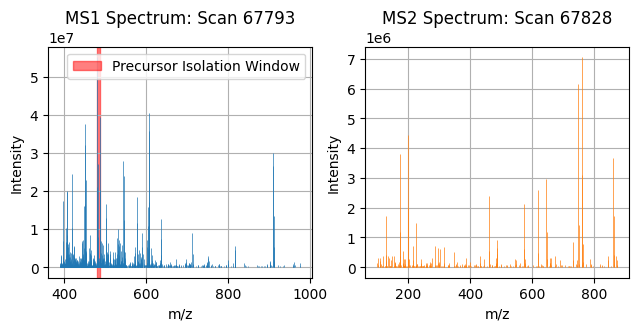

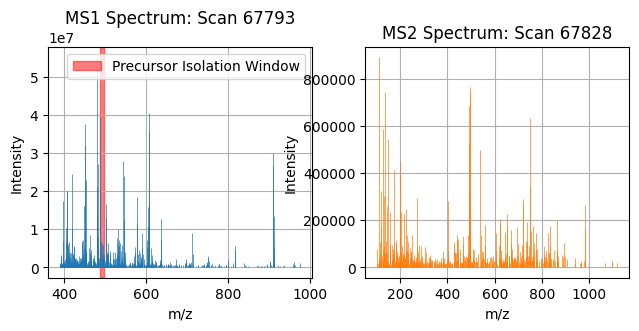

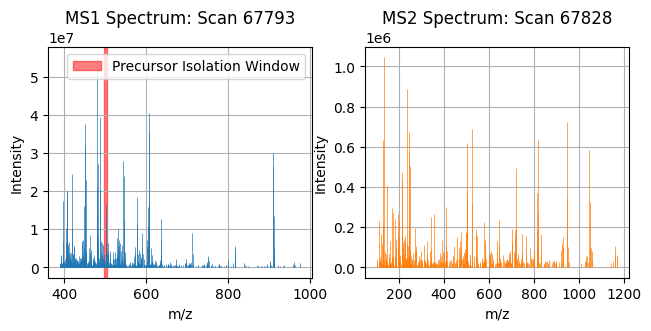

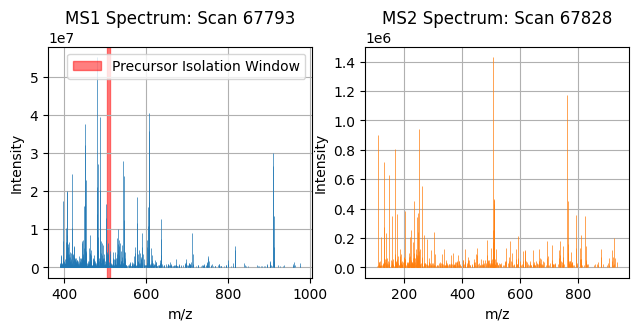

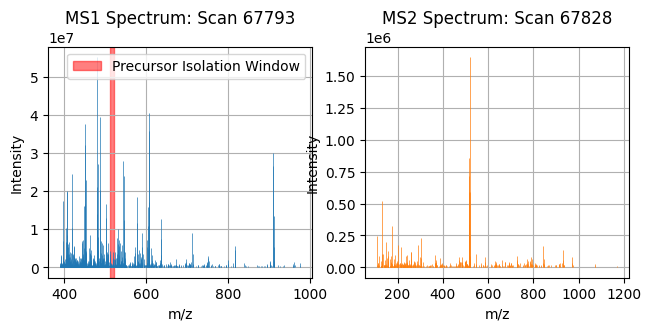

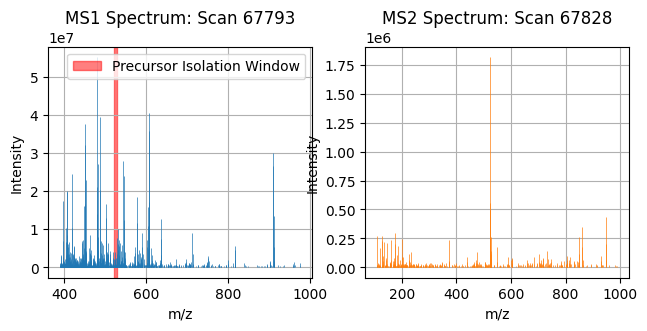

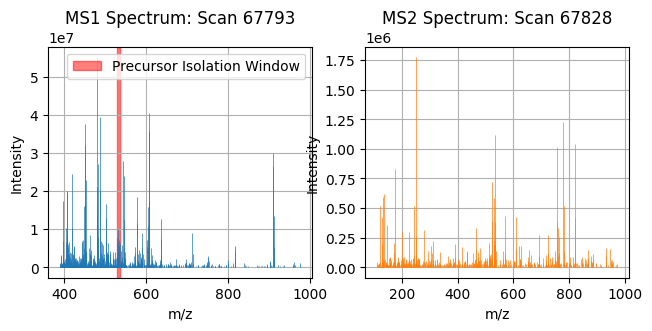

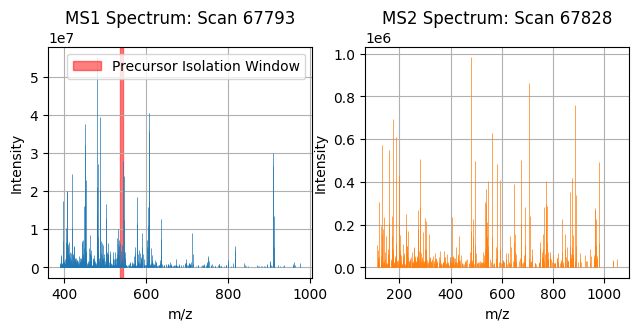

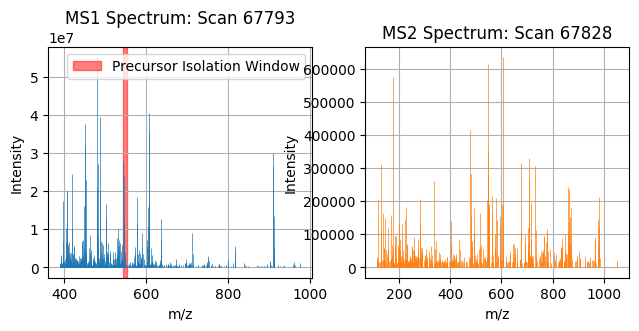

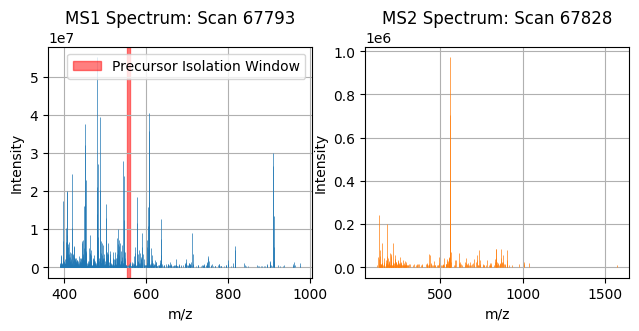

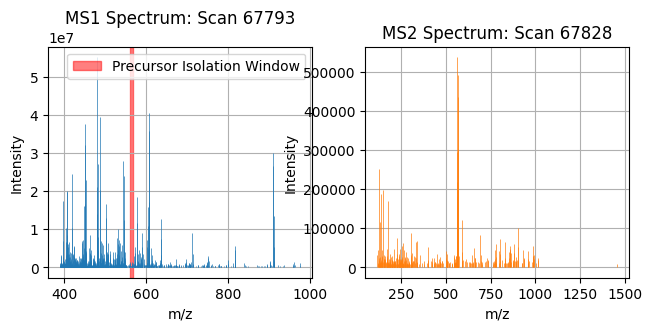

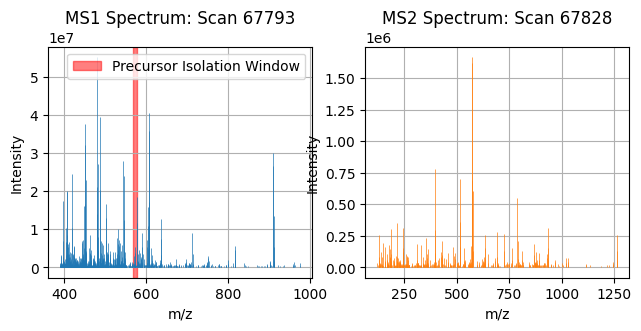

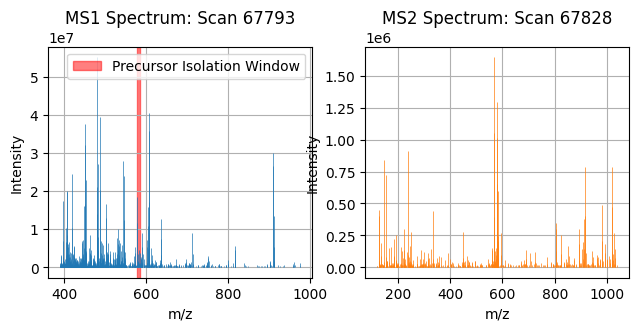

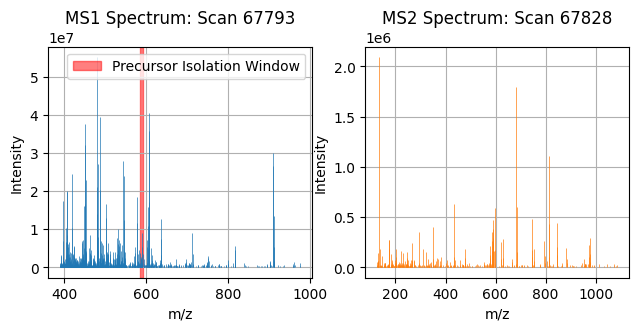

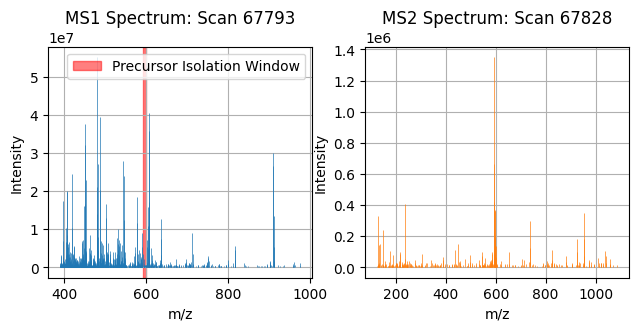

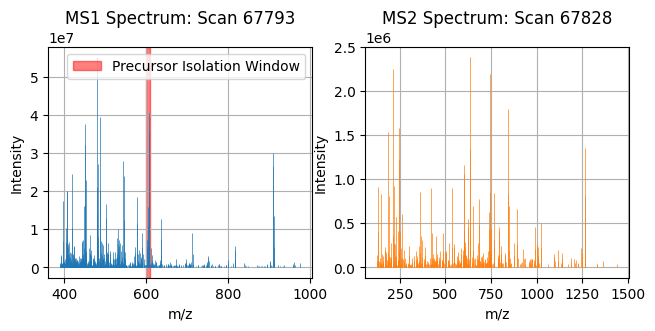

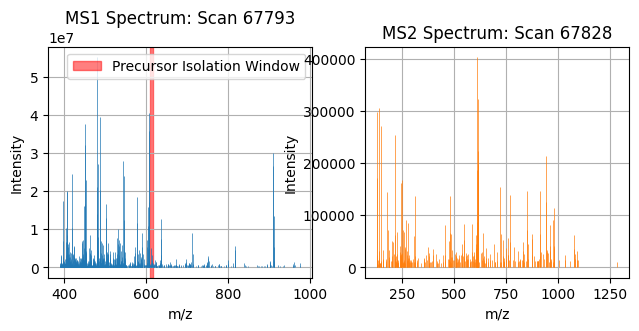

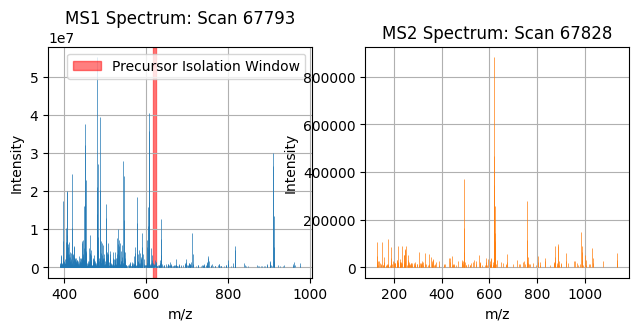

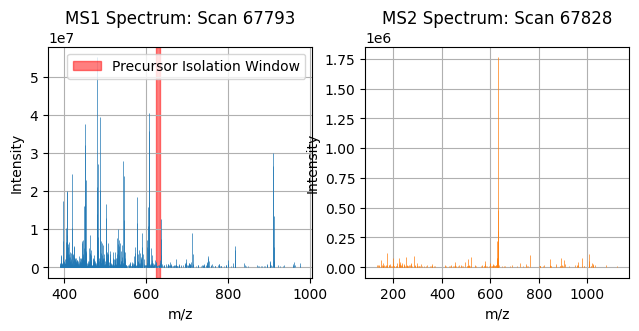

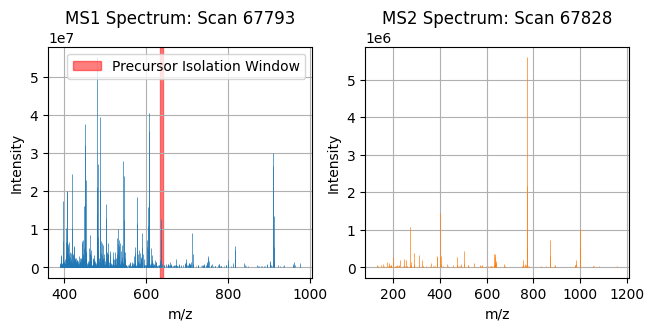

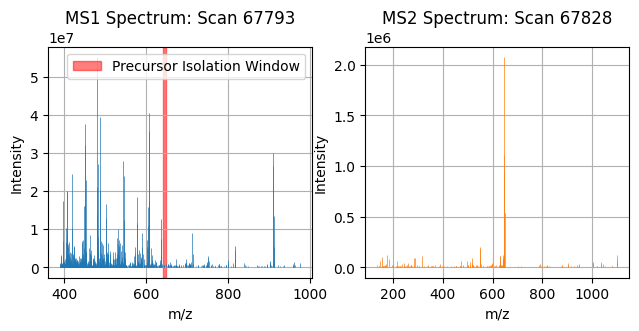

In [8]:
next_n_spectra = 25
for i in range(0,next_n_spectra):
    try:
        mz1, intensity1, ms1_spectrum, mz2, intensity2, ms2_spectrum, precursor_mz2, isolation_width = get_ms_specs_scan(ms1_to_scan,ms1_to_ms2,random_ms1,random_ms1+i)
    except KeyError:
        print("Could not find the associated spectrum, skipping ...")
    create_ms_plot(mz1,intensity1, ms1_spectrum, mz2, intensity2, ms2_spectrum, precursor_mz2, isolation_width)

# 4. Count peaks in MS1 and MS2

In this section, we compare the number of peaks observed in MS1 and MS2 spectra between DDA and DIA. For MS1 spectra the counting is restricted to peaks within the isolation windows. This limit on counting is done to emphasize the difference in thge amount of different precursors that are fragmented. This difference in unique precursors has important implications on the identification ambiguity as we will see later.

Lets start counting!

![count](https://media1.tenor.com/m/CSYSqLuo6fwAAAAC/sesame-street-muppets.gif)

First we define a function that can read the mzML file and count the spectrum. Importantly, for the MS1 only those peaks within the isolation window are counted:

In [9]:
def count_peaks_ms(mzml_path, ms1_mode=True):
    num_peaks = []
    ms1_spectrum = None

    # Open mzML file using pyteomics
    with mzml.MzML(mzml_path) as reader:
        for spectrum in tqdm(reader):
            # Process MS1 spectra
            if spectrum['ms level'] == 1:
                ms1_spectrum = spectrum['m/z array']
                continue

            if spectrum['ms level'] == 2 and ms1_spectrum is not None and ms1_mode:
                precursor_mz = spectrum['precursorList']['precursor'][0]['isolationWindow']['isolation window target m/z']
                offset = spectrum['precursorList']['precursor'][0]['isolationWindow']['isolation window lower offset']

                lower_val = precursor_mz - offset
                upper_val = precursor_mz + offset

                # Count the number of peaks from MS1 spectrum within the isolation window
                num_peaks.append(
                    sum([1 for mz in ms1_spectrum if lower_val < mz < upper_val])
                )
            if spectrum['ms level'] == 2 and not ms1_mode:
                num_peaks.append(
                    sum([1 for mz in spectrum['m/z array']])
                )
                
    return num_peaks

def process_file_ms2(mzml_path):
    exp = MSExperiment()
    MzMLFile().load(mzml_path, exp)
    spectra = [
        (s.get_peaks()[0], s.get_peaks()[1])
        for s in exp.getSpectra()
        if s.getMSLevel() == 2
    ]

    num_peaks = [len(mz) for mz, intensity in spectra]

    return num_peaks


Next we start counting the peaks in the MS1 and MS2 for both DIA and DDA:

In [10]:
mzml_file_dia = "./LFQ_Orbitrap_AIF_Human_01.mzML"
mzml_file_dda = "./LFQ_Orbitrap_DDA_Human_01.mzML"

num_peaks_dia_ms1 = count_peaks_ms(mzml_file_dia)
num_peaks_dda_ms1 = count_peaks_ms(mzml_file_dda)

num_peaks_dia_ms2 = count_peaks_ms(mzml_file_dia, ms1_mode=False)
num_peaks_dda_ms2 = count_peaks_ms(mzml_file_dda, ms1_mode=False)

100%|████████████████████████████████████████████████████████████████████████| 143136/143136 [01:31<00:00, 1556.34it/s]


In [11]:
num_peaks_dict = {}

num_peaks_dict["LFQ_Orbitrap_AIF_Human_01.mzML_ms1"] = num_peaks_dia_ms1
num_peaks_dict["LFQ_Orbitrap_DDA_Human_01.mzML_ms1"] = num_peaks_dda_ms1

num_peaks_dict["LFQ_Orbitrap_AIF_Human_01.mzML_ms2"] = num_peaks_dia_ms2
num_peaks_dict["LFQ_Orbitrap_DDA_Human_01.mzML_ms2"] = num_peaks_dda_ms2

As we would like to plot the count distributions, we define the following function. Here each value counted in the histogram represents a single MS1 or MS2 spectrum. 

In [12]:
def plot_ms_counts(
        num_peaks_dict,
        dda_key,
        dia_key,
        bin_range=list(range(0, 260)),
        dda_label="DDA Orbitrap",
        dia_label="DIA Orbitrap",
        title="MS1 peaks in a spectrum"
    ):
    plt.hist(
        num_peaks_dict[dda_key],
        bins=bin_range,
        color="blue",
        alpha=0.5,
        label=dda_label,
    )
    plt.hist(
        num_peaks_dict[dia_key],
        bins=bin_range,
        color="red",
        alpha=0.5,
        label=dia_label,
    )
    
    plt.title(title)
    
    plt.legend()
    plt.xlabel("Peaks in spectrum (#)")
    plt.ylabel("Frequency (#)")
    plt.tight_layout()
    plt.show()

Lets do the counting for the MS1 first:

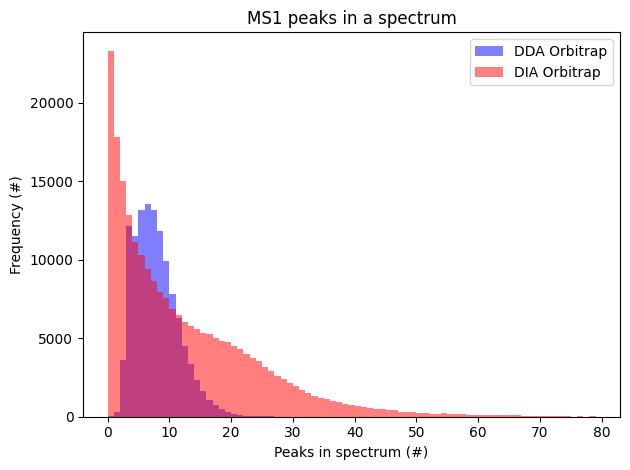

In [13]:
dia_key = "LFQ_Orbitrap_AIF_Human_01.mzML_ms1"
dda_key = "LFQ_Orbitrap_DDA_Human_01.mzML_ms1"

plot_ms_counts(
    num_peaks_dict,
    dda_key,
    dia_key,
    bin_range=list(range(0, 80)),
    dda_label="DDA Orbitrap",
    dia_label="DIA Orbitrap",
    title="MS1 peaks in a spectrum"
)

And for the MS2:

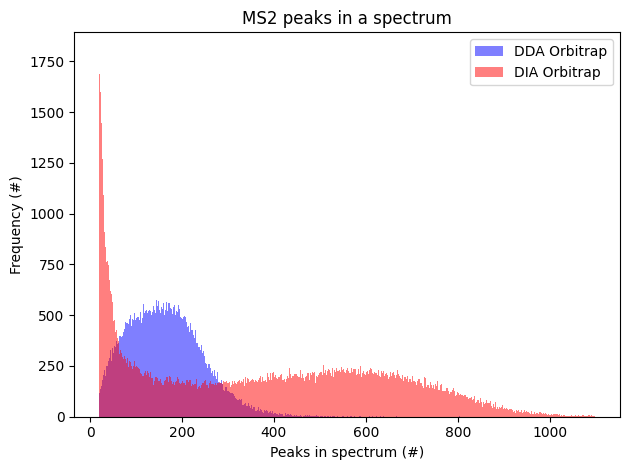

In [14]:
dia_key = "LFQ_Orbitrap_AIF_Human_01.mzML_ms2"
dda_key = "LFQ_Orbitrap_DDA_Human_01.mzML_ms2"

plot_ms_counts(
    num_peaks_dict,
    dda_key,
    dia_key,
    bin_range=list(range(20, 1100)),
    dda_label="DDA Orbitrap",
    dia_label="DIA Orbitrap",
    title="MS2 peaks in a spectrum"
)

Food for thought:
- Do the distributions look like what you expected? What did you expect?
- Why is the DIA distribution bimodal for the MS2?
- What are the consequences for further analysis that we isolated more unique precursors and thus have more unique peaks in the MS2?
    - What is the consequence for ambiguity
    - What is the consequence for FDR
    - We do not count overlapping transitions (or fragmentation peaks) from different precursors, is this even more of a problem for DIA?

# 5. Ambiguity - multi interpretation

Identification ambiguity is the uncertainty or lack of specificity in making an identification. As we saw in the previous section there are MS2 spectra with many more peaks compared for DIA compared to DDA. This can lead to multi-interpretability or ambiguity of the spectra. While DIA relies heavily on extracted ion chromatograms (XICs) of transitions, we will ignore this in the following analysis of ambiguity. Here we will interpret the delta masses per spectrum and try to interpret each delta mass as potentially contributing to an identification.

Essentially this means taking all paiwise distances between peaks and counting them towards an amino acid (potentially with modification) if they match the theoretical mass distance:

![count_deltamass](https://github.com/CompOmics/EUPA_2025_DIA/blob/main/workshop/img/5_deltamass_count.png?raw=true)

First we define all the possible delta masses of amino acids and their modifications:

In [15]:
amino_acid_masses = {
    # Standard amino acids
    "A": 71.03711,
    "R": 156.10111,
    "N": 114.04293,
    "D": 115.02694,
    "C": 103.00919,
    "E": 129.04259,
    "Q": 128.05858,
    "G": 57.02146,
    "H": 137.05891,
    "I": 113.08406,
    "L": 113.08406,
    "K": 128.09496,
    "M": 131.04049,
    "F": 147.06841,
    "P": 97.05276,
    "S": 87.03203,
    "T": 101.04768,
    "W": 186.07931,
    "Y": 163.06333,
    "V": 99.06841,

    # Modified residues
    "C[Carbamidomethyl]": 160.03065,     # 103.00919 + 57.02146
    "M[Oxidation]": 147.03540,           # 131.04049 + 15.99491
    "H[Oxidation]": 153.05382,           # 137.05891 + 15.99491
    "Q[Pyro-glu]": 111.03203,            # 128.05858 − 17.02655
    "E[Pyro-glu]": 111.03203,            # 129.04259 − 18.01056
    "W[Oxidation]": 202.07422,           # 186.07931 + 15.99491
    "N[Deamidated]": 115.02695,          # 114.04293 + 0.98402
    "Q[Deamidated]": 129.04260,          # 128.05858 + 0.98402
    "S[Phospho]": 166.99836,             # 87.03203 + 79.96633
    "T[Phospho]": 181.01398,             # 101.04768 + 79.96633
    "Y[Phospho]": 243.02966,             # 163.06333 + 79.96633
    "K[Acetyl]": 170.10552,              # 128.09496 + 42.01056
    "K[Methyl]": 142.11061,              # 128.09496 + 14.01565
    "K[Dimethyl]": 156.12626,            # 128.09496 + 28.03130
    "K[Trimethyl]": 170.14191,           # 128.09496 + 42.04695
    "K[Propionyl]": 185.11642,           # 128.09496 + 57.02146
    "K[Butyryl]": 199.13031,             # 128.09496 + 71.03535
    "K[Formyl]": 156.10572,              # 128.09496 + 28.01076
    "K[Malonyl]": 186.11146,             # 128.09496 + 58.01650
    "K[Succinyl]": 200.12535,            # 128.09496 + 72.03039
    "R[Methyl]": 170.11676,              # 156.10111 + 14.01565
    "R[Dimethyl]": 184.13241,            # 156.10111 + 28.03130
    "R[Trimethyl]": 198.14806,           # 156.10111 + 42.04695
}

all_masses = {**amino_acid_masses}

# Converting to a sorted list of masses for easier indexing
sorted_masses = sorted(all_masses.items(), key=lambda x: x[1])
amino_acid_deltas = [mass for name, mass in sorted_masses]
amino_acid_deltas_names = [name for name, mass in sorted_masses]

Next we define some helper functions for quantifying ambiguity. Five functions in total:

1. **calculate_pairwise_distances** - takes the mz array and delta mz values, based on the tolerance we count the occurence of delta m/z values of all pairwise distances
2. **bin_and_sum_intensities** - alternatively, you can bin these distances and sum the intensities --> this is not used in this analysis
3. **process_file** - get all MS2 spectra from the mzML file
4. **prepare_ambiguity_plotting** - prepare the counted pairwise distance occurences for plotting, mainly collapsing all possible amino acid (+modifications)
5. **plot_ambiguity_data** - make boxplots of counts for different search spaces

In [16]:
def calculate_pairwise_distances(mzs, amino_acid_deltas, tolerance=0.005, max_mz=300.0):
    mzs = np.array(mzs)
    if len(mzs) < 2:  # Ensure there are at least two m/z values to compare
        return np.zeros(len(amino_acid_deltas), dtype=int)
    mz_diffs = np.abs(mzs[:, np.newaxis] - mzs)
    mz_diffs = np.triu(mz_diffs, k=1)
    mz_i, mz_j = np.where((mz_diffs > 0) & (mz_diffs <= max_mz))
    if not mz_i.size:  # No valid differences found
        return np.zeros(len(amino_acid_deltas), dtype=int)
    mz_diffs = mz_diffs[mz_i, mz_j]
    comparison = np.abs(mz_diffs[:, np.newaxis] - amino_acid_deltas) <= tolerance
    return np.sum(comparison, axis=0)

def bin_and_sum_intensities(pairs):
    bins = np.arange(0, 300.005, 0.005)
    intensity_sums = np.zeros(len(bins))
    for mz1, mz2, diff, intensity_sum in pairs:
        idx = int(diff / 0.005)
        intensity_sums[idx] += intensity_sum
    return intensity_sums

def process_file(mzml_path, amino_acid_deltas):
    exp = MSExperiment()
    MzMLFile().load(mzml_path, exp)
    spectra = [
        (s.get_peaks()[0], s.get_peaks()[1])  # select_top_peaks
        for s in exp.getSpectra()
        if s.getMSLevel() == 2
    ]
    
    results_matrix = []
    for mzs, intensities in tqdm(spectra):
        if len(mzs) > 1:
            results_matrix.append(calculate_pairwise_distances(mzs, amino_acid_deltas))
        else:
            results_matrix.append(
                np.zeros(len(amino_acid_deltas), dtype=int)
            )  # Ensure consistent shape
    return results_matrix

def prepare_ambiguity_plotting(results_dict,dia_key,dda_key):
    # Lists to store values for plotting the distributions
    dia_values = []
    dda_values = []
    labels = []
    
    for i in range(20, len(amino_acid_masses.keys()) + 1):
        selected_cols = list(amino_acid_masses.keys())[0:i]
    
        # Calculate the sums of the selected columns
        dia_count_all = results_dict[dia_key][selected_cols].sum(axis=1)
        dda_count_all = results_dict[dda_key][selected_cols].sum(axis=1)
    
        # Filter sums greater than 10 and collect values
        dia_values.append(dia_count_all[dia_count_all > 10].values)
        dda_values.append(dda_count_all[dda_count_all > 10].values)
    
        labels.append(str(i))
    return dia_values, dda_values, labels

def plot_ambiguity_data(dia_values,dda_values,labels):
    # Initialize the figure and axis for the plot
    plt.figure(figsize=(10, 5))
    ax = plt.gca()

    # Plotting boxplots
    positions_dia = [x - 0.2 for x in range(20, len(amino_acid_masses.keys()) + 1)]
    positions_dda = [x + 0.2 for x in range(20, len(amino_acid_masses.keys()) + 1)]
    central_positions = [x for x in range(20, len(amino_acid_masses.keys()) + 1)]
    
    ax.boxplot(
        dia_values,
        positions=positions_dia,
        widths=0.4,
        patch_artist=True,
        boxprops=dict(facecolor="red"),
        medianprops=dict(color="black"),
        showfliers=False,
    )
    ax.boxplot(
        dda_values,
        positions=positions_dda,
        widths=0.4,
        patch_artist=True,
        boxprops=dict(facecolor="blue"),
        medianprops=dict(color="black"),
        showfliers=False,
    )
    
    # Custom legend
    legend_elements = [
        Patch(facecolor="red", edgecolor="black", label="DIA"),
        Patch(facecolor="blue", edgecolor="black", label="DDA"),
    ]
    ax.legend(handles=legend_elements, loc="upper left")
    
    # Setting the plot limits, labels, title, and x-ticks
    ax.set_ylim(0, 4000)
    ax.set_xlabel("Number of variable modifications")
    ax.set_ylabel("Sum count delta m/z values")
    ax.set_title("")
    ax.set_xticks(central_positions)
    ax.set_xticklabels(labels, rotation=45)
    
    # Show the plot
    plt.show()

Load the mzML files and cont the delta m/z values of all pairwise distances for which an amino acid (+modification) exist.

In [17]:
results_dict = {}
files = [
    "./LFQ_Orbitrap_AIF_Human_01.mzML",
    "./LFQ_Orbitrap_DDA_Human_01.mzML"
]
result_dir = "./"

for file in files:
    result = process_file(file, amino_acid_deltas)
    result = pd.DataFrame(result)
    result.columns = amino_acid_deltas_names
    results_dict[os.path.basename(file)] = result

100%|█████████████████████████████████████████████████████████████████████████| 118387/118387 [07:50<00:00, 251.88it/s]


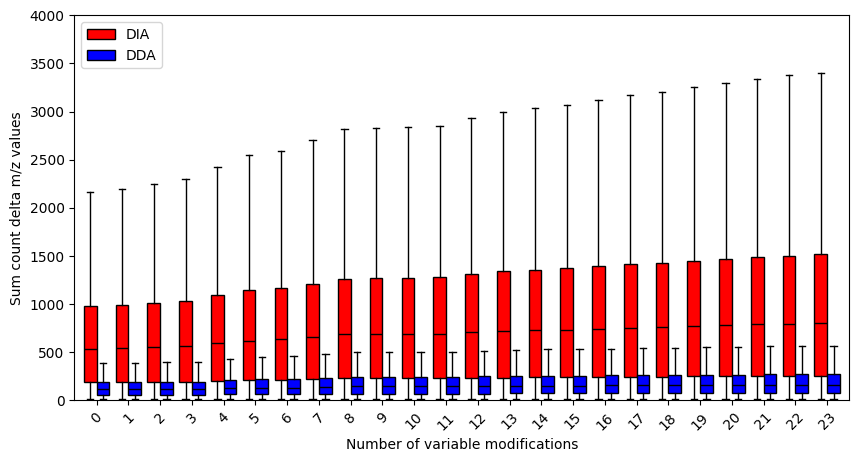

In [18]:
dia_key = "LFQ_Orbitrap_AIF_Human_01.mzML"
dda_key = "LFQ_Orbitrap_DDA_Human_01.mzML"

dia_values, dda_values, labels = prepare_ambiguity_plotting(results_dict,dia_key,dda_key)
labels = np.array(list(map(int,labels))) - 20
plot_ambiguity_data(dia_values,dda_values,labels)

Food for thought:

- Can you think of ways to reduce ambiguity?
    - Instrument settings
    - Instrument improvements
    - Software/algorithm improvements
- It is not just the combinatorial issue, shared/non-shared fragmentation peaks of precursors is a problem

# 6. Search space size 

Say something about the peptide centric approach!!!

Next we define some helper functions for plotting. There are in total four functions:

1. **tryptic_digest_pyopenms** - perform a tryptic digest of a fasta with pyopenms
2. **calculate_possibilities** - calculate number of peptidoforms based on amino acid and modification combinations
3. **modification_list_to_dict** - go from a list of amino acid and modification combinations to a list
4. **apply_modifications** - overarching function that return total number of peptidoforms

In [19]:
def tryptic_digest_pyopenms(
    file_path,
    min_len=5,
    max_len=50,
    missed_cleavages=2,
    decoy_method="reverse",
    decoy_prefix="rev_",
    seq_types=["original", "decoy"],
):
    # Read the FASTA file
    fasta = pms.FASTAFile()
    entries = []
    fasta.load(file_path, entries)

    # Set up the enzyme digestion
    digestor = pms.ProteaseDigestion()
    digestor.setEnzyme("Trypsin")
    digestor.setMissedCleavages(missed_cleavages)

    peptides = []
    for entry in entries:
        # Process both original and decoy sequences
        for seq_type in seq_types:
            if seq_type == "original":
                protein_sequence = str(entry.sequence)
            else:
                if decoy_method == "reverse":
                    protein_sequence = str(entry.sequence)[::-1]
                elif decoy_method == "scramble":
                    seq_list = list(str(entry.sequence))
                    random.shuffle(seq_list)
                    protein_sequence = "".join(seq_list)
                else:
                    raise ValueError(
                        "Invalid decoy method. Choose 'reverse' or 'scramble'."
                    )

            protein_name = entry.identifier.split()[
                0
            ]  # Adjust based on your FASTA format

            # Perform the tryptic digest
            result = []
            digestor.digest(pms.AASequence.fromString(protein_sequence), result)

            for peptide in result:
                peptide_sequence = str(peptide.toString())
                len_pep_seq = len(peptide_sequence)
                start = protein_sequence.find(peptide_sequence)
                end = start + len_pep_seq
                if "X" in peptide_sequence:
                    continue
                if len_pep_seq >= min_len and len_pep_seq <= max_len:
                    if seq_type == "original":
                        peptides.append(
                            (
                                protein_name,
                                start,
                                end,
                                f"{protein_name}|{start}|{end}",
                                peptide_sequence,
                            )
                        )
                    else:
                        peptides.append(
                            (
                                f"{decoy_prefix}{protein_name}",
                                start,
                                end,
                                f"{decoy_prefix}{protein_name}|{start}|{end}",
                                peptide_sequence,
                            )
                        )
    return peptides
    
def calculate_possibilities(possibilities,max_mods=3):
    N = len(possibilities)  # Total number of positions
    total = 0

    # Iterate over the number of positions that can vary (0 to 3)
    for k in range(0, max_mods+1):
        # Generate all combinations of positions that can vary
        for varying_positions in combinations(range(N), k):
            # Calculate the product of possibilities for the chosen positions
            product = 1
            for pos in varying_positions:
                product *= possibilities[pos]
            # Add this product to the total sum
            total += product

    return total

def modification_list_to_dict(all_amino_acids, modifications_search_space):
    modification_dict = defaultdict(list)
    for modification, amino_acids in modifications_search_space:
        for aa in amino_acids:
            modification_dict[aa].append(modification)

    for aa in all_amino_acids:
        modification_dict[aa].insert(0, "")

    modification_dict = dict(modification_dict)
    return modification_dict

def apply_modifications(
    peptides, modifications, charges=[2, 3, 4, 5], max_var_mods=3, max_len=30, min_len=7
):
    unique_peptides = set([p[-1] for p in peptides])
    tot_num = 0
    tot_num_fragments = 0

    for idx, peptide_seq in enumerate(unique_peptides):
        if len(peptide_seq) > max_len or len(peptide_seq) < min_len:
            continue
        all_pos = [len(modifications[aa]) - 1 for aa in peptide_seq]
        poss = calculate_possibilities(all_pos, max_mods=max_var_mods) * len(charges)
        tot_num += poss
        tot_num_fragments += poss * len(peptide_seq) * 2

    return tot_num

First we define the search space. For example, this includes the different charge states and possible modifications.

In [20]:
# Your modification data
modifications_search_space = [
    ("[Oxidation]", ["M"]),
    ("[OxidationP]", ["P"]),
    ("[Carbamidomethyl]", ["C"]),
    ("[Alkyl]", ["C"]),
    ("[DeamidationN]", ["N"]),
    ("[DeamidationQ]", ["Q"]),
    ("[PhosphorylationS]", ["S"]),
    ("[PhosphorylationT]", ["T"]),
    ("[PhosphorylationY]", ["Y"]),
    ("[Nitrosyl]", ["C"]),
    ("[OxidationC]", ["C"]),
    ("[Methyl]", ["K"]),
    ("[MethylR]", ["R"]),
    ("[Dimethyl]", ["K"]),
    ("[DimethylR]", ["R"]),
    ("[Trimethyl]", ["K"]),
    ("[CitrullinationR]", ["R"]),
    ("[Propionyl]", ["K"]),
    ("[Butyryl]", ["K"]),
    ("[Malonyl]", ["K"]),
    ("[Succinyl]", ["K"]),
    ("[Glutarylation]", ["K"]),
    ("[Crotonyl]", ["K"]),
    ("[Hydroxyisobutyryl]", ["K"]),
    ("[Biotin]", ["K"]),
    ("[GG]", ["K"]),
    ("[NitroY]", ["Y"]),
]

charge_min_range = [1] #you can define a range with: range(1, 3)
charge_max_range = [2] #you can define a range with: range(1, 3)
maximum_length_range = [35]
max_var_mods_range = [2]
missed_cleavages = [2]
num_var_mods = range(0, len(modifications_search_space[0:25]))

combinations_df = product(
    charge_min_range,
    charge_max_range,
    maximum_length_range,
    max_var_mods_range,
    missed_cleavages,
    num_var_mods,
)

df = pd.DataFrame(
    combinations_df,
    columns=[
        "charge_min",
        "charge_max",
        "maximum_length",
        "max_var_mods",
        "missed_cleavages",
        "num_var_mods",
    ],
)

Next we obtain the search space size for all possible different combinations:

In [21]:
fasta_analyze = "data/human_22032024.fasta"

# Define all standard amino acids
all_amino_acids = set(
    "ABCDEFGHIKLMNPQRSTUVWXY"
)  # 20 standard amino acids + additional ones that can be in the fasta, they are ignored if they are not in there

search_space_list = []
for idx,r in tqdm(df.iterrows()):
    i = r["num_var_mods"]
    # Read peptides from fasta using a tryptic digest function
    peptides = tryptic_digest_pyopenms(
        fasta_analyze,
        min_len=6,
        max_len=r["maximum_length"],
        missed_cleavages=int(r["missed_cleavages"]),
    )

    modification_dict = modification_list_to_dict(
        all_amino_acids, modifications_search_space[0:i+1]
    )

    # Apply modifications to peptides
    all_peptidoforms = apply_modifications(
        peptides,
        modification_dict,
        charges=list(range(r["charge_min"], r["charge_max"])),
        max_var_mods=r["max_var_mods"],
    )
    print(f"Total number of unique peptidoforms: {all_peptidoforms}")
    search_space_list.append(all_peptidoforms)
    
df["search_space"] = search_space_list

1it [01:54, 114.10s/it]

Total number of unique peptidoforms: 5522331


2it [03:48, 114.31s/it]

Total number of unique peptidoforms: 12710552


3it [05:42, 114.36s/it]

Total number of unique peptidoforms: 16551888


4it [07:37, 114.47s/it]

Total number of unique peptidoforms: 21447330


5it [09:32, 114.57s/it]

Total number of unique peptidoforms: 29591409


6it [11:26, 114.42s/it]

Total number of unique peptidoforms: 42622036


7it [13:21, 114.47s/it]

Total number of unique peptidoforms: 70638034


8it [15:16, 114.66s/it]

Total number of unique peptidoforms: 92518927


9it [17:10, 114.62s/it]

Total number of unique peptidoforms: 104992999


10it [19:05, 114.67s/it]

Total number of unique peptidoforms: 117190854


11it [20:59, 114.57s/it]

Total number of unique peptidoforms: 130442815


12it [22:54, 114.64s/it]

Total number of unique peptidoforms: 166834065


13it [24:49, 114.78s/it]

Total number of unique peptidoforms: 204321138


14it [26:45, 114.95s/it]

Total number of unique peptidoforms: 247606779


15it [28:40, 115.13s/it]

Total number of unique peptidoforms: 291580409


16it [30:35, 115.10s/it]

Total number of unique peptidoforms: 341760441


17it [32:30, 115.06s/it]

Total number of unique peptidoforms: 392220628


18it [34:25, 115.04s/it]

Total number of unique peptidoforms: 449295051


19it [36:20, 115.00s/it]

Total number of unique peptidoforms: 510347864


20it [38:17, 115.61s/it]

Total number of unique peptidoforms: 575379067


21it [40:13, 115.86s/it]

Total number of unique peptidoforms: 644388660


22it [42:10, 115.99s/it]

Total number of unique peptidoforms: 717376643


23it [44:06, 116.06s/it]

Total number of unique peptidoforms: 794343016


24it [46:03, 116.35s/it]

Total number of unique peptidoforms: 875287779


25it [47:59, 115.20s/it]

Total number of unique peptidoforms: 960210932


Lets plot the number of variable modifications against the search space size:

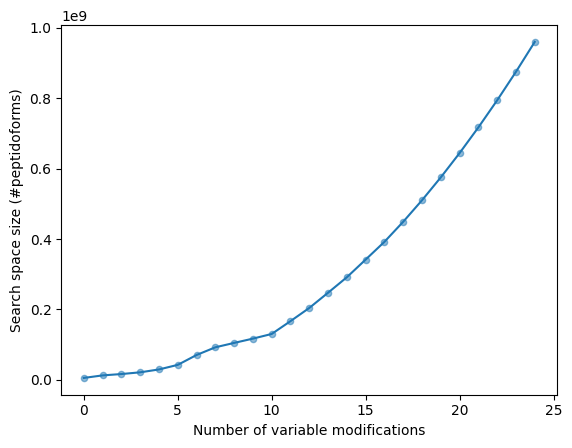

In [22]:
plt.scatter(df["num_var_mods"], df["search_space"],s=20,alpha=0.5)
plt.plot(df["num_var_mods"], df["search_space"])
plt.xlabel("Number of variable modifications")
plt.ylabel("Search space size (#peptidoforms)")
plt.show()

![search_space](https://github.com/CompOmics/EUPA_2025_DIA/blob/main/workshop/img/search_space.png?raw=true)

Food for thought:

- What is a search space that is feasible in terms of hardware limitations?
- Do you always need to look for many variable modifications? In what cases yes/no?
- Are there other ways to intelligently reduce search space? (e.g., non-peptide-centric, elution windows, heuristics, ...)

# 7. Prediction comparison

As we have seen in section 5 the ambiguity in DIA can be problematic. This can be partly resolved by using more dimensions of the data. While the m/z dimension is highly (i.e., the most) informative dimension. The intensity of fragment ions, retention time, and collisional cross section can contain sufficient information to disambiguate identifications. This is one of the main reasons predicted libraries for DIA will contain predicted fragment intensities and retention times, even when not searching for modifications. However, as we are interested in modifications, these predictions need to be modification aware. If they are not, they can even cause the opposite effect, where the use of predictions causes a loss in sensitivity and specificity.

First to see how predictions cause substantially different LC-MS behavior we will have a look at syntethic peptides with and without modifications. For these pairs we will plot the delta in observed retention time. First we read the data from [Zolg et al.](https://www.sciencedirect.com/science/article/pii/S1535947620320624?via%3Dihub).

In [23]:
df_tr = pd.read_csv("data/prosit_ptm_2020.csv")
df_tr.fillna("",inplace=True)

# Separate unmodified and modified peptides
df_unmod = df_tr[df_tr["modifications"] == ""].rename(columns={"tr": "tr_unmod"})
df_mod = df_tr[df_tr["modifications"] != ""]

# Merge on sequence to get corresponding unmodified tr for each modified one
df_merged = pd.merge(df_mod, df_unmod[["seq", "tr_unmod"]], on="seq", how="left")

# Calculate RT difference
df_merged["delta_tr"] = df_merged["tr"] - df_merged["tr_unmod"]
df_merged = df_merged.sort_values(by="seq")

Next we get the modification type per peptidoform, irrespective of the position. We filter the peptidoforms based on the occurence of only a single modification type and pair them together based on unmodified and modified.

In [24]:
def filter_outliers(group):
    q1 = group["delta_tr"].quantile(0.25)
    q3 = group["delta_tr"].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # Return group without outliers
    return group[(group["delta_tr"] >= lower_bound) & (group["delta_tr"] <= upper_bound)]

def extract_mod_types(mod_str):
    if not mod_str:
        return []
    parts = mod_str.split('|')
    return [parts[i] for i in range(1, len(parts), 2)]

df_mods = df_merged.dropna(subset=["delta_tr"])

# Get modification type, irrespective of position
df_mods["mod_types"] = df_mods["modifications"].apply(extract_mod_types)

# Only take those peptidoforms with a single modification type
df_single_mod = df_mods[df_mods["mod_types"].apply(len) == 1].copy()

# Explode into separate rows for each modification type (only one per row now)
df_exploded = df_single_mod.explode("mod_types")

df_vp = df_exploded.dropna(subset=["delta_tr", "mod_types"])

# Limit to top modifications for clarity
top_mods = df_vp["mod_types"].value_counts().nlargest(10).index
df_vp = df_vp[df_vp["mod_types"].isin(top_mods)]

# Filter outliers for violin plot only
df_vp_filtered = df_vp.groupby("mod_types").apply(filter_outliers).reset_index(drop=True).copy()
sns.set_style("whitegrid")

# Calculate median ΔRT per modification type
mod_order = df_vp_filtered.groupby("mod_types")["delta_tr"].median().sort_values(ascending=False).index

C:\Users\robbi\AppData\Local\Temp\ipykernel_18624\963858074.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mods["mod_types"] = df_mods["modifications"].apply(extract_mod_types)
C:\Users\robbi\AppData\Local\Temp\ipykernel_18624\963858074.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_vp_filtered = df_vp.groupby("mod_types").apply(filter_outliers).reset_index(drop=True).copy()


Lets now plot the difference in retention time between the pairs:

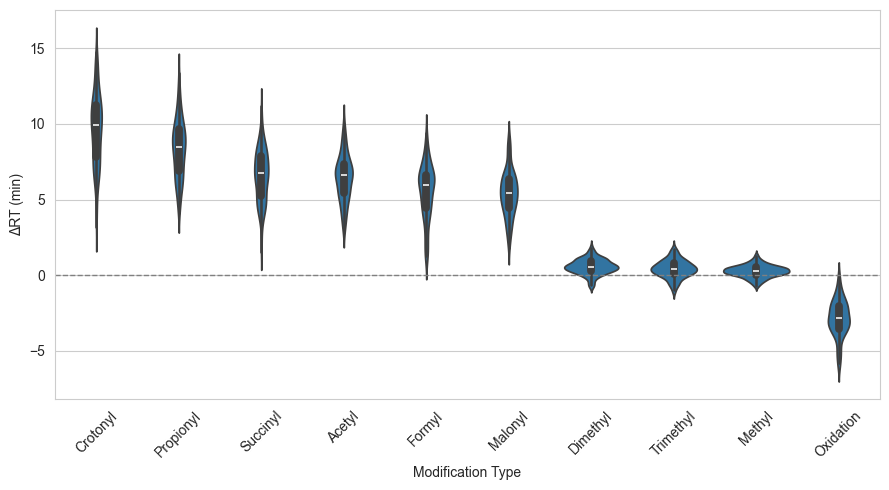

In [25]:
plt.figure(figsize=(9, 5.0))

# Pass the sorted order to violinplot
sns.violinplot(x="mod_types", y="delta_tr", data=df_vp_filtered, order=mod_order)

# Optional: show all points with swarmplot (uncomment if desired)
# sns.swarmplot(x="mod_types", y="delta_tr", data=df_vp, order=mod_order, color='k', size=2, alpha=0.6)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xticks(rotation=45)
plt.xlabel("Modification Type")
plt.ylabel("ΔRT (min)")
plt.tight_layout()
plt.show()

Next we will read identifications from DIA-NN for the Van Puyvelde data:

In [26]:
df = pd.read_csv("data/report.tsv",sep="\t")
df_filtered = df[df["Q.Value"] < 0.01]

df_grad_length = abs(df["iRT"].max()-df["iRT"].min())
df_grad_length_ptm = abs(df_mods["tr"].max()-df_mods["tr"].min())

diann_predictions = df_filtered["RT"] - df_filtered["Predicted.RT"]
df_mods = df_mods.copy()
df_mods["mod_types"] = df_mods["mod_types"].apply(lambda x: x[0] if isinstance(x, list) and x else None)

No we compare the shifts in retention time induced by modifications and identifications made by DIA-NN:

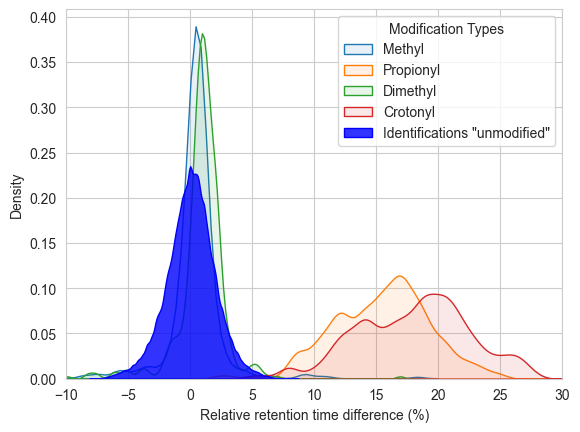

In [27]:
df_mods["adjusted_delta_tr"] = (df_mods["delta_tr"]) / df_grad_length_ptm * 100

selected_mods = ["Methyl", "Propionyl", "Dimethyl", "Crotonyl"]
# Plot KDE for each mod_type group
for mod_type in selected_mods:
    subset = df_mods[df_mods["mod_types"] == mod_type]
    sns.kdeplot(subset["adjusted_delta_tr"], bw_adjust=0.5, fill=True, alpha=0.1, label=mod_type)

sns.kdeplot(diann_predictions, bw_adjust=0.5, color='blue', fill=True, alpha=0.8,  label='Identifications "unmodified"')
plt.xlim(-10,30)
plt.legend()
plt.xlabel('Relative retention time difference (%)')
plt.ylabel('Density')

plt.legend(title='Modification Types')
plt.show()

Food for thought:

- What would happen if we search with a library created with prediction models that are not modification aware?
    - What happens in the best case? (e.g., think about the effect on rescoring)
    - What happens in the worst case? (e.g., think about the effect on elution windows 'heuristics')
- Wat modifications are supported by what tools?